MemorySaver:

A simple in-memory checkpoint saver that gives your LangGraph agents short-term memory within the same running process.

Langgraph uses a checkpointer(Memory saver-RAM or Persistent memory-DB(Both MemorySaver and Persistent memory are short term memory only)) to automatically save the graph state after each step

MemorySaver stores the full graph state including messages, tool outputs, and routing metadata in process memory, which is lost on restart

It’s great for local use and prototyping but not persistent across restarts

Stored only in RAM,Gone after app restart

Cannot continue conversations after restart



**Persistent checkpointers store the same state in durable storage like Postgres or Redis.**

Persistent checkpointers store the same state in external storage, allowing conversations and workflows to resume across restarts and instances.

A checkpointer is responsible for:

Saving the graph state

Loading the graph state

Keyed by a thread_id

The state can include:

Messages

Tool results

Intermediate variables

Agent routing decisions

Same as Memory saver, but only difference is 

**It Stores state in external storage**

So it Survives restarts

Can resume anytime

##### A superstep is one discrete execution cycle where the graph state is loaded, nodes execute, conditional edges are evaluated, and a checkpoint is written.

EG our Graph :START → llm_tool → (conditional) → tools → llm_tool → END
Execution for query: “Find recent papers on RAG”

Superstep	Nodes executed	Why boundary?
Superstep1)	llm_tool	State checkpointed after LLM decides tool needed
Superstep2)	tools	Tool executes → state updated → checkpoint
Superstep3)	llm_tool	Final summarization → state checkpointed → END

How do we know the boundary?

The graph pauses after llm_tool decides a tool call is needed → checkpoint → this ends superstep 1

The next execution resumes from tools node → superstep 2

Then llm_tool runs final summarization → superstep 3

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_tavily import TavilySearch

c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\pydantic\_internal\_fields.py:198: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  warnings.warn(
c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\pydantic\_internal\_fields.py:198: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  warnings.warn(


In [2]:
tavily = TavilySearch()
tavily.invoke('current date')

{'query': 'current date',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datetoday.net/',
   'title': "What is the date today? Today's Date",
   'content': 'Today\'s Date is Mon Jan 19 2026. About Date Today. The term "Date Today" refers to the current calendar date as determined by a system\'s internal clock',
   'score': 0.98187524,
   'raw_content': None},
  {'url': 'https://www.rapidtables.com/tools/todays-date.html',
   'title': "Today's Date | Current date now - RapidTables.com",
   'content': "This page includes the following information: Today's date: day of week, month, day, year. Current time: hours, minutes, seconds.",
   'score': 0.94891727,
   'raw_content': None},
  {'url': 'https://isotropic.org/date/',
   'title': "Today's Date - isotropic.org",
   'content': "Today's Date. If this is working, then. Today is: Gregorian: Monday, 19 January 2026. Mayan: Long count = 13.0.13.4.17; tzolkin = 10 Caban; haab = 15 Muan.",
   'sc

In [3]:
arxiv = ArxivQueryRun(api_wrapper=ArxivAPIWrapper(doc_content_chars_max=500))

In [4]:
arxiv.run('imporving camera quality using ai')

'Published: 2025-01-06\nTitle: Foundations of GenIR\nAuthors: Qingyao Ai, Jingtao Zhan, Yiqun Liu\nSummary: The chapter discusses the foundational impact of modern generative AI models on information access (IA) systems. In contrast to traditional AI, the large-scale training and superior data modeling of generative AI models enable them to produce high-quality, human-like responses, which brings brand new opportunities for the development of IA paradigms. In this chapter, we identify and introduce '

In [5]:
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(doc_content_chars_max=500))

In [6]:
wikipedia.invoke(' pm of india names')

'Page: Prime Minister of India\nSummary: The prime minister of India (ISO: Bhārat kē Pradhānamantrī) is the head of government of the Republic of India. Executive authority is vested in the prime minister and his chosen Council of Ministers, despite the president of India being the nominal head of the executive.  The prime minister has to be a member of one of the houses of bicameral Parliament of India, alongside heading the respective house. The prime minister and the cabinet are at all times re'

In [7]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')
os.environ['LANGSMITH_API_KEY']=os.getenv('LANGSMITH_API_KEY')
os.environ['LANGSMITH_PROJECT']='Agent_React'


In [8]:
# Here docstring is important because llm will read this . so give proper desc.

def multiply(a:int,b:int)->int:
    """
    Multiplies two integers and returns the result.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a*b


def add(a:int,b:int)->int:
    """
    Adds two integers and returns the result.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The addition of a and b.
    """
    return a+b

def divide(a:int,b:int)->int:
    """
    Divides the first integer by the second and returns the result.

    Args:
        a (int): The numerator.
        b (int): The denominator.

    Returns:
        int: The result of dividing a by b.
    """
    return a/b

In [9]:
tools =[add,multiply,divide,wikipedia,arxiv,tavily]

In [10]:
# Initialize chat model
from langchain_groq import ChatGroq

llm =ChatGroq(model="llama-3.1-8b-instant")

In [11]:
llm_with_tools =llm.bind_tools(tools=tools)

In [12]:
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from langgraph.prebuilt import ToolNode,tools_condition
from typing import Annotated,TypedDict
from IPython.display import Image,display


In [13]:
class State(TypedDict):
    messages :Annotated[list[AnyMessage],add_messages]


In [14]:
def llm_tool(state: State):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}


In [15]:
builder =StateGraph(State)

builder.add_node('llm_tool',llm_tool)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'llm_tool')
builder.add_conditional_edges('llm_tool',tools_condition) #If the LLM’s answer is sufficient, tools_condition can be written to skip all tools. If the LLM cannot answer confidently or detects a tool is needed (like arxiv for papers, wikipedia for general info), the corresponding tool node is executed.
builder.add_edge('tools','llm_tool') # this is react architecture
builder.add_edge('llm_tool',END)







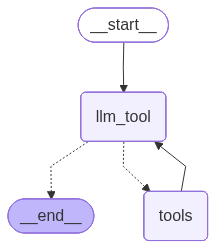

In [18]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [21]:
# Specify the Config 

config ={"configurable":{"thread_id":"1"}}

In [17]:
import gradio as gr
from langchain.messages import HumanMessage

In [ ]:
def chat(query,chat_history):
    result = graph_memory.invoke({"messages":HumanMessage(content=query)},config=config)
    print(result)
    return result['messages'][-1].content

In [ ]:
gr.ChatInterface(chat,type='messages').launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='what is 5+2 multipled by 18', additional_kwargs={}, response_metadata={}, id='e79f5256-9021-4e21-9b25-6c9d8c3e27d0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9f3p7j112', 'function': {'arguments': '{"a":5,"b":2}', 'name': 'add'}, 'type': 'function'}, {'id': '0mcvdn40z', 'function': {'arguments': '{"a":7,"b":18}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 2185, 'total_tokens': 2221, 'completion_time': 0.05645097, 'completion_tokens_details': None, 'prompt_time': 0.443312096, 'prompt_tokens_details': None, 'queue_time': 0.364302955, 'total_time': 0.499763066}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bdadd-e2db-7a11-95ba-9637d947658c-0', tool_calls=[{'name': 'add', 'args': {'a': 5, 'b': 2}, 'id': '9